In [59]:
import pandas.io.sql as sql
from lxml.html import parse
from urllib.request import urlopen
import pandas as pd
import urllib 
import numpy as np
from matplotlib.pyplot import plot,savefig 
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import statsmodels.api as sm
import scipy.stats as stats 

In [60]:
def get_sina_stock(stockid,start="1990-12-19",end=pd.datetime.now(),isstock=True,fuquan=True):    
    def _unpack(row, kind='td'):
        elts = row.findall('.//%s' % kind)
        return [val.text_content().strip() for val in elts] # .strip()鍘绘帀\r\t\n涔嬬被鐨勫瓧绗�    
    def parse_options_data(table,isstock,fuquan):
        rows = table.findall('.//tr')
        data = [_unpack(r) for r in rows[2:]]
        if isstock & fuquan:
            colnames = ['date','open','high','close','low','vol','amount','ratio'] # 鍥為伩涓枃澶勭悊
        else:
            colnames = ['date','open','high','close','low','vol','amount']
        data= pd.DataFrame(data,columns=colnames)
        data.index=pd.to_datetime(data["date"])
        data=data.drop("date",axis=1)
        data=data.ix[range(len(data)-1,-1,-1)]
        return  data
    data=pd.DataFrame()
    daterange=pd.date_range(start,end,freq="Q")
    daterange=daterange.insert(len(daterange),daterange[-1]+1)
    for cq in daterange: 
        if isstock:
            if fuquan:
                url='http://vip.stock.finance.sina.com.cn/corp/go.php/vMS_FuQuanMarketHistory/stockid/'+str(stockid)+'.phtml?year='+str(cq.year)+'&jidu='+str(cq.month/3)
            else:
                url='http://vip.stock.finance.sina.com.cn/corp/go.php/vMS_MarketHistory/stockid/'+str(stockid)+'.phtml?year='+str(cq.year)+'&jidu='+str(cq.month/3)            
        else:            
            url='http://vip.stock.finance.sina.com.cn/corp/go.php/vMS_MarketHistory/stockid/'+str(stockid)+'/type/S.phtml?year='+str(cq.year)+'&jidu='+str(cq.month/3)
        try:
            parsed = parse(urlopen(url))
        except:
            print ("download failed for year=" +str(cq.year)+',  jidu='+str(cq.month/3))
            continue
        doc = parsed.getroot()
        tables=doc.findall('.//table')     
        da= tables[-1] # last table 19 for fuquan data and 4 for index
        datatem = parse_options_data(da,isstock,fuquan)
        data=pd.concat([data,datatem])
    return pd.DataFrame(data[start:end],dtype=float)    

In [61]:
#1.计算每只股票的月收益率，选择若干只(>=小组人数)分析其分布。
data1=get_sina_stock('600615','1991-1-1','2016-11-16').close
data2=get_sina_stock('600606','1991-1-1','2016-11-16').close
data3=get_sina_stock('600621','1991-1-1','2016-11-16').close
data4=get_sina_stock('600638','1991-1-1','2016-11-16').close
data1.name='600615'#丰华股份
data2.name='600606'#绿地控股
data3.name='600621'#华鑫股份
data4.name='600638'#新黄浦
data=pd.concat([data1,data2,data3,data4],axis=1)

In [62]:
rtn_m=data.resample('M').last().pct_change().dropna()
rtn_m.describe()
rtn_m

,600615,600606,600621,600638
date,,,,
1993-04-30,0.457335,0.536670,0.672745,0.822535
1993-05-31,-0.252074,-0.217368,-0.333061,-0.337602
1993-06-30,0.089252,0.007519,0.001939,0.040000
1993-07-31,-0.066082,-0.050005,-0.112902,-0.060256
1993-08-31,0.008489,-0.015791,0.047479,0.249591
1993-09-30,0.046777,0.026741,0.064608,0.009935
1993-10-31,-0.043789,-0.015618,0.028989,-0.039809
1993-11-30,0.242990,0.103180,0.285208,0.180472
1993-12-31,-0.227070,-0.266192,-0.164380,-0.169428


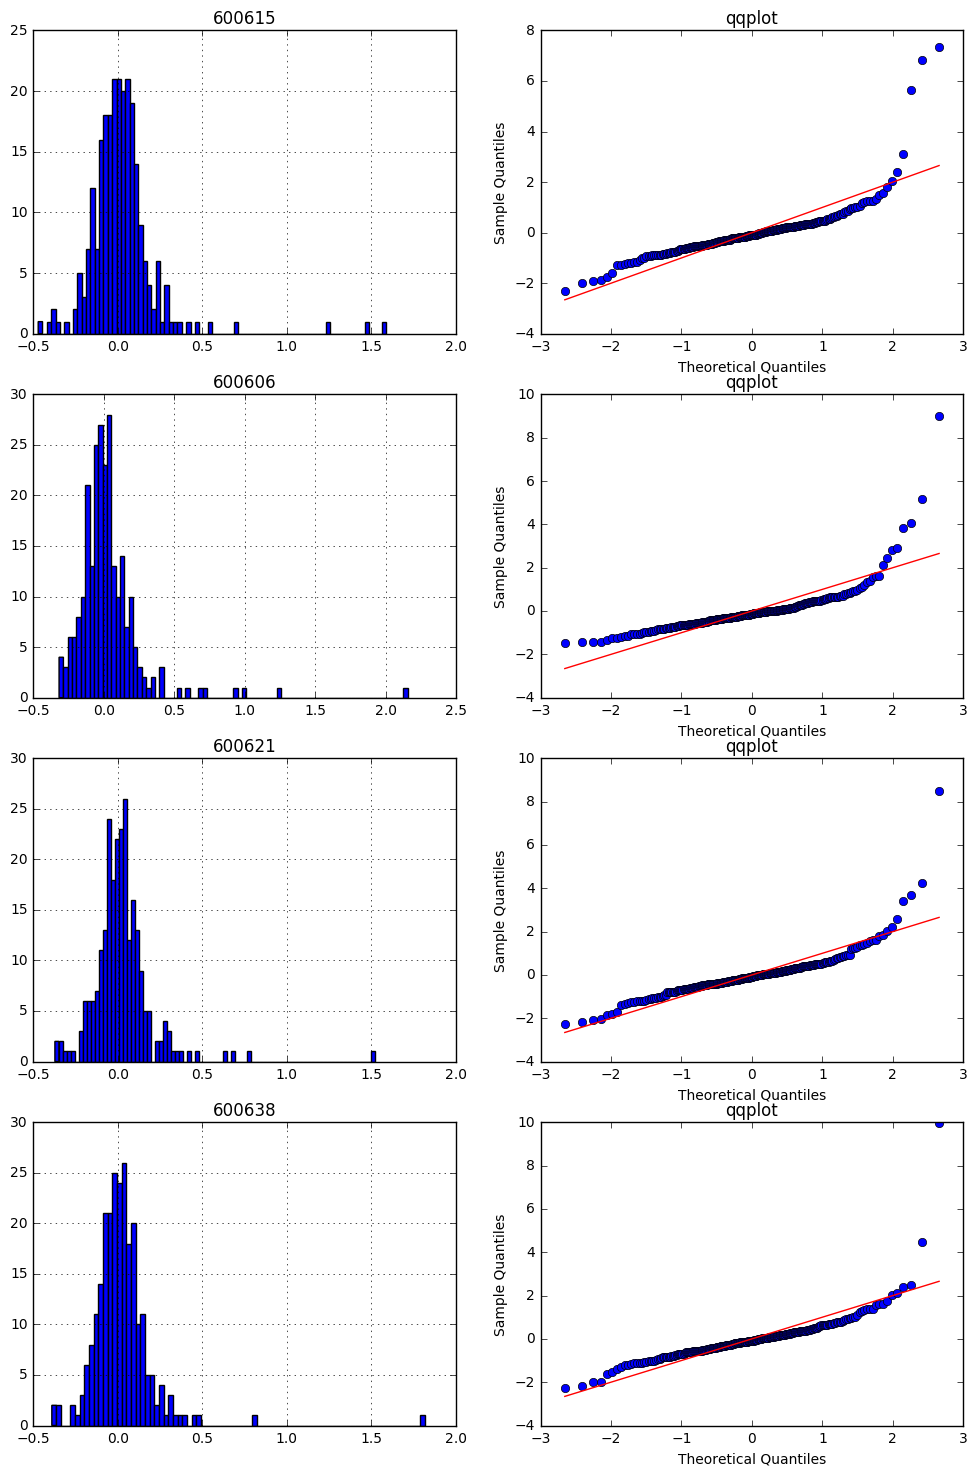

In [63]:
stock_list=['600615','600606','600621','600638']
fig = plt.figure(figsize=(12,18))
for i in range(len(stock_list)):
    ax1=fig.add_subplot(4, 2, 2*i+1)
    rtn_m[stock_list[i]].hist(bins=80,ax=ax1)
    plt.title(stock_list[i])
    ax2=fig.add_subplot(4, 2, 2*(i+1))
    sm.qqplot(rtn_m[stock_list[i]],stats.norm,line='s',fit=True,ax=ax2)
    plt.title('qqplot')

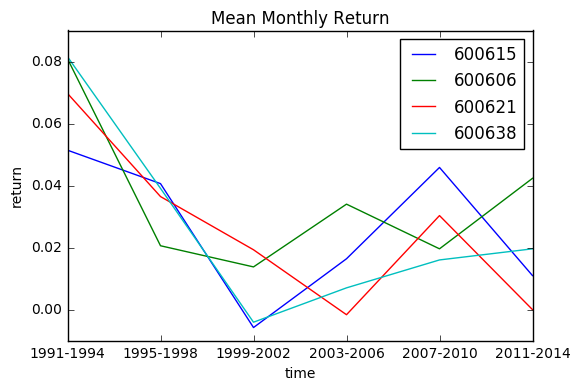

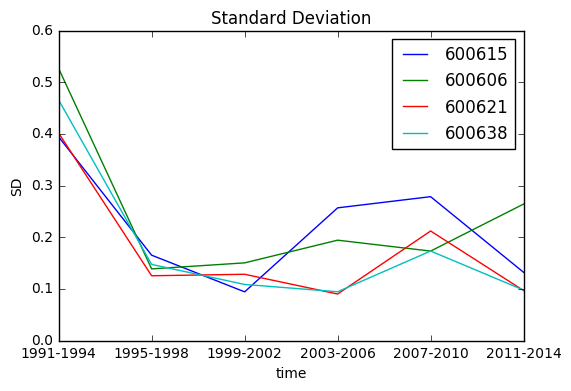

In [64]:
####################################################################################################################
#2.计算每段时间内行业内每只股票的月期望收益率和标准差,画两个图形，分别给出收益率和标准差的走势图形并作简单说明。   #
#要求：横轴为时间，纵轴为预期收益率或标准差，每只股票用一种颜色的线条表示，并将所有股票对应的线条画在一个坐标系内。#
####################################################################################################################
%matplotlib inline
Emu = DataFrame()
Emu[0] = rtn_m['1991':'1994'].mean()
Emu[1] = rtn_m['1995':'1998'].mean()
Emu[2] = rtn_m['1999':'2002'].mean()
Emu[3] = rtn_m['2003':'2006'].mean()
Emu[4] = rtn_m['2007':'2010'].mean()
Emu[5] = rtn_m['2011':'2014'].mean()
Emu = Emu.transpose()
Emu.index = ['1991-1994','1995-1998','1999-2002','2003-2006','2007-2010','2011-2014']
Emu.plot()
plt.title('Mean Monthly Return')
plt.xlabel('time')
plt.ylabel('return')

Esigma = DataFrame()
Esigma[0] = rtn_m['1991':'1994'].std()
Esigma[1] = rtn_m['1995':'1998'].std()
Esigma[2] = rtn_m['1999':'2002'].std()
Esigma[3] = rtn_m['2003':'2006'].std()
Esigma[4] = rtn_m['2007':'2010'].std()
Esigma[5] = rtn_m['2011':'2014'].std()
Esigma = Esigma.transpose()
Esigma.index = ['1991-1994','1995-1998','1999-2002','2003-2006','2007-2010','2011-2014']
Esigma.plot()
plt.title('Standard Deviation')
plt.xlabel('time')
plt.ylabel('SD')

1991-1994    0.081529
1995-1998    0.039075
1999-2002   -0.004098
2003-2006    0.006983
2007-2010    0.015987
2011-2014    0.019575
Name: 600638, dtype: float64
1991-1994    0.465533
1995-1998    0.147283
1999-2002    0.108480
2003-2006    0.094355
2007-2010    0.173164
2011-2014    0.097548
Name: 600638, dtype: float64


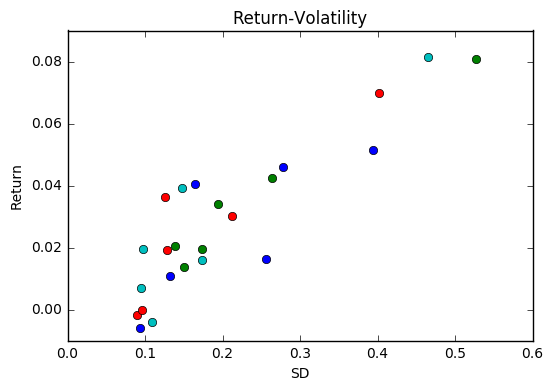

In [65]:
#3.以标准差为横轴，期望收益率和纵轴，用上面计算的所有数据作散点图，不同股票用不同颜色，同一支股票的不同时间得到的数据用相同的颜色。
plt.figure(1)
for i in range(len(stock_list)):
    list1 = Emu[stock_list[i]]
    list2 = Esigma[stock_list[i]]
    plt.plot(list2,list1,'o')
print(list1)
print(list2)
plt.title('Return-Volatility')
plt.xlabel('SD')
plt.ylabel('Return')

1991 to 1994
          600615    600606    600621    600638
600615  1.000000  0.970945  0.977778  0.975761
600606  0.970945  1.000000  0.968444  0.942578
600621  0.977778  0.968444  1.000000  0.973920
600638  0.975761  0.942578  0.973920  1.000000
1995 to 1998
          600615    600606    600621    600638
600615  1.000000  0.341836  0.537846  0.455745
600606  0.341836  1.000000  0.585867  0.405574
600621  0.537846  0.585867  1.000000  0.598904
600638  0.455745  0.405574  0.598904  1.000000
1999 to 2002
          600615    600606    600621    600638
600615  1.000000  0.491993  0.456848  0.733762
600606  0.491993  1.000000  0.396122  0.559146
600621  0.456848  0.396122  1.000000  0.608661
600638  0.733762  0.559146  0.608661  1.000000
2003 to 2006
          600615    600606    600621    600638
600615  1.000000  0.312337  0.608776  0.462112
600606  0.312337  1.000000  0.303376  0.288054
600621  0.608776  0.303376  1.000000  0.648752
600638  0.462112  0.288054  0.648752  1.000000
2007 to 

(0.1, 1)

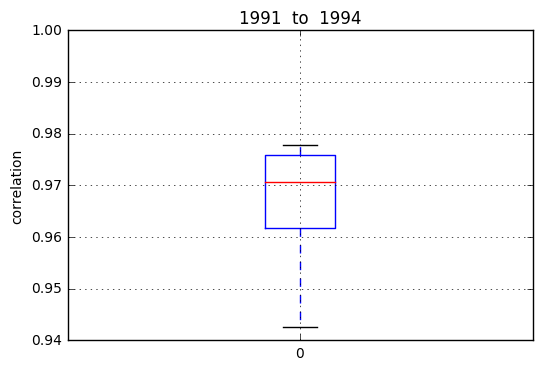

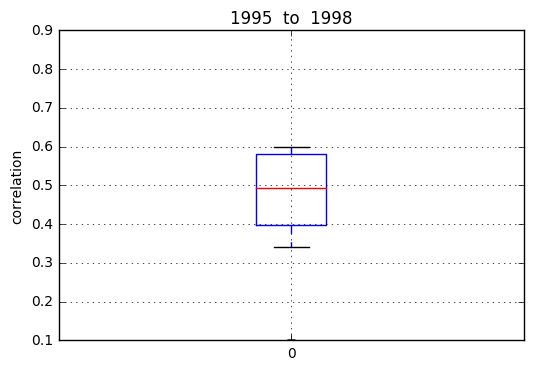

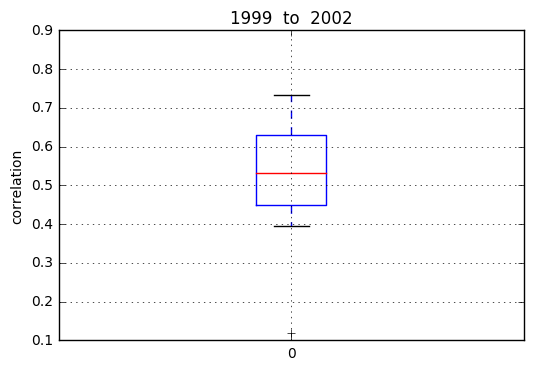

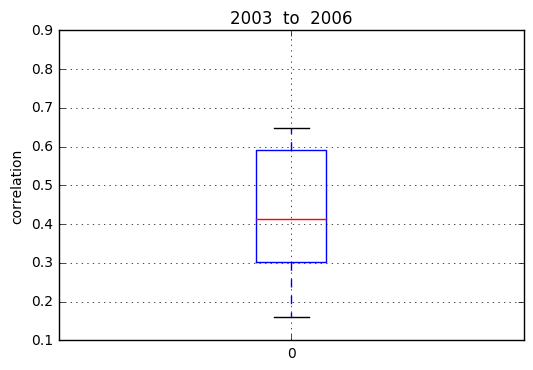

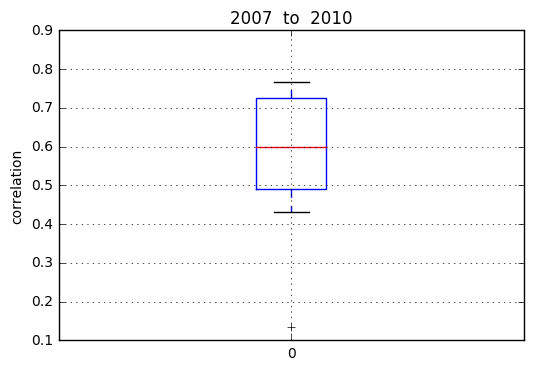

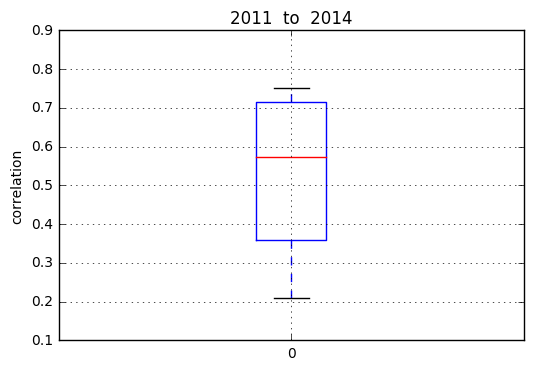

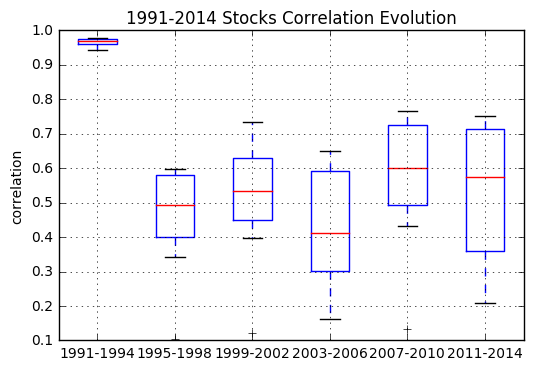

In [66]:
#############################################################################################
#4.从上面股票中，对每个时间窗，计算股票收益率之间的相关系数矩阵，只取下三角形中不是1的数据。#
#  统计每个时间段相关系数的最大值，最小值，均值，25%和75%分位点（表格汇总）。               #
#  用box图画出相关系数的分布，横坐为时间轴，每个时间段对应一个分布图                        #
#############################################################################################


time_list=['1991','1992','1993','1994','1995','1996','1997','1998','1999','2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011','2012','2013','2014','2015','2016']
for i in range(0,len(time_list)-2,4):
    corr=rtn_m[time_list[i]:time_list[i+3]].corr()
    print(time_list[i]+' to '+time_list[i+3])
    print(corr)
    
    summary=[]
    for j in range(len(stock_list)):
        for k in range(j+1,len(stock_list)):
            summary.append(corr[stock_list[j]][stock_list[k]])
    
    if i==0:
        y=DataFrame(summary).describe()
        y.plot(kind='box')
        plt.grid(True)
        plt.ylabel('correlation')
        plt.ylim(0.94,1.0)
    else:
        z=DataFrame(summary).describe()
        y=pd.concat([y,z],axis=1)
        z.plot(kind='box')
        plt.grid(True)
        plt.ylabel('correlation')
        plt.ylim(0.1,0.9)
    plt.title(time_list[i]+'  to  '+time_list[i+3])

y.columns=['1991-1994','1995-1998','1999-2002','2003-2006','2007-2010','2011-2014']
print('\n',y)
y.plot(kind='box')
plt.title('1991-2014 Stocks Correlation Evolution')
plt.grid(True)
plt.ylabel('correlation')
plt.ylim(0.1,1)

In [67]:
######################################################
#进一步分析上面得到的结果，讨论如下问题：            #
#(a). 总体上看，高收益，高风险的模式是否成立？       #
#(b). 时间周轴上看，每只股票的收益风险特性是否稳定？ #
#(c). 相关系数的分布是否稳定？                       #
######################################################


#(a). 总体上看，这一模式成立。从Return-Volatility图上可以看出， 所有点基本符合低标准差对应低收益率、高标准差对应高收益率的规律。
#(b). 但从时间轴上来看，比如深蓝色点的风险收益情况，出现了低风险对应高收益率的情况（从左向右数第3个点和第4个点）
#(c). 相关系数分布不稳定，均值和标准差在每个时间段均有显著变化。

26


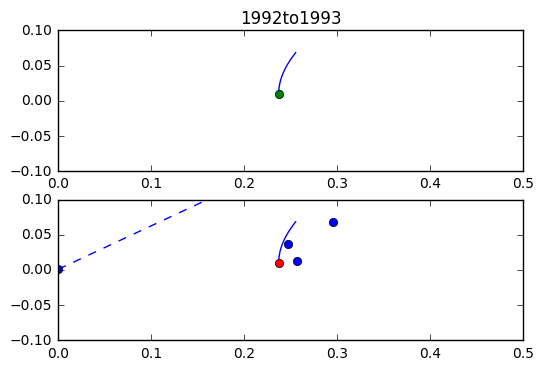

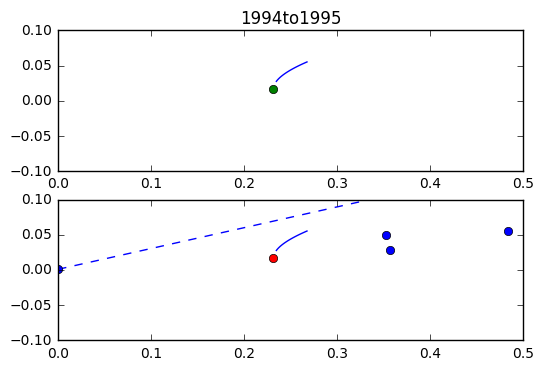

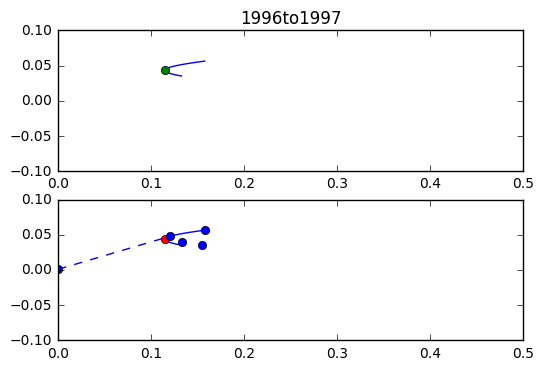

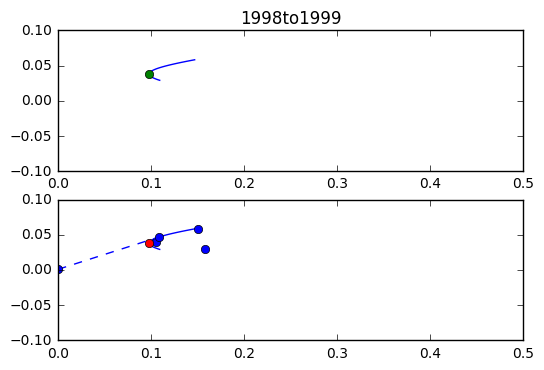

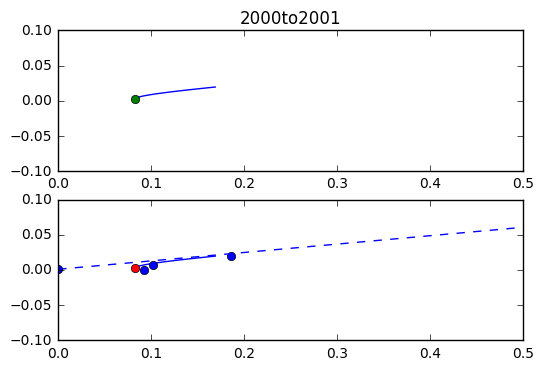

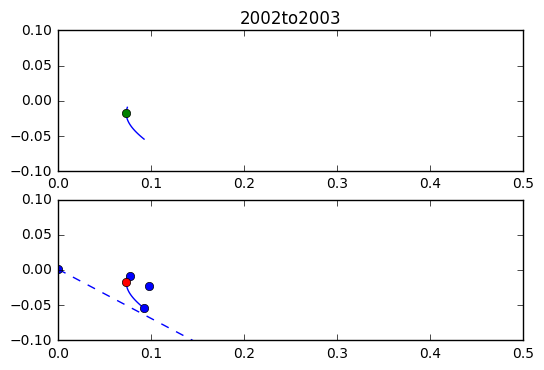

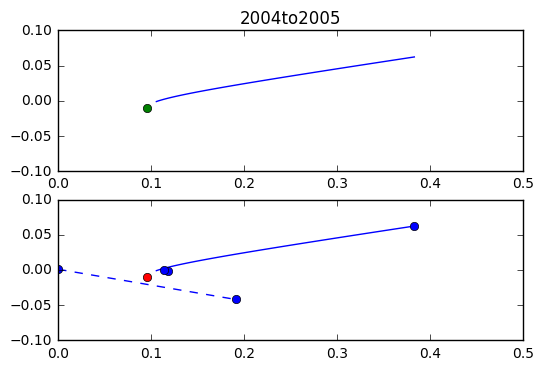

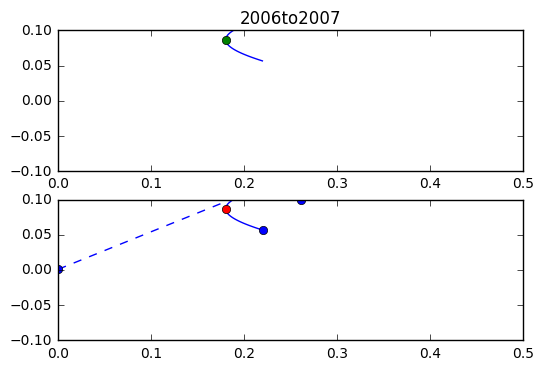

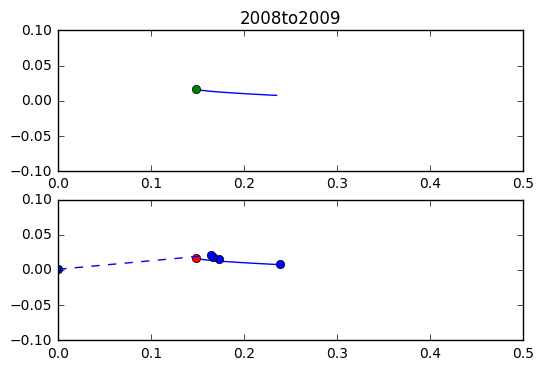

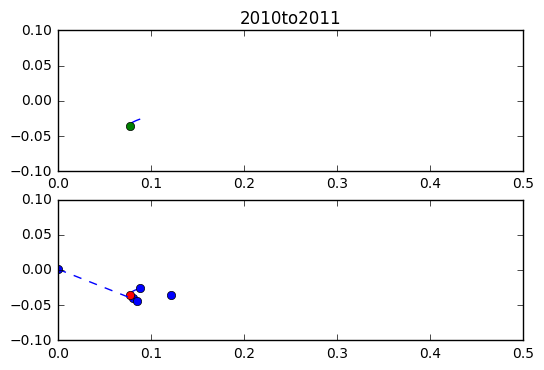

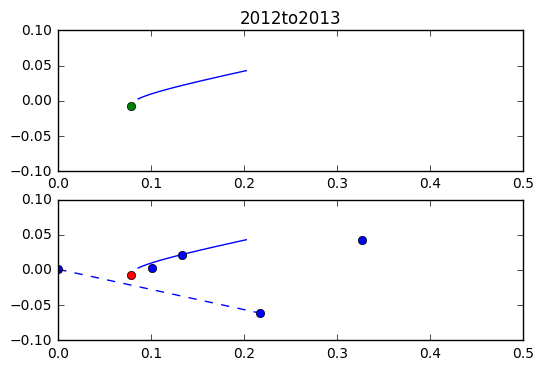

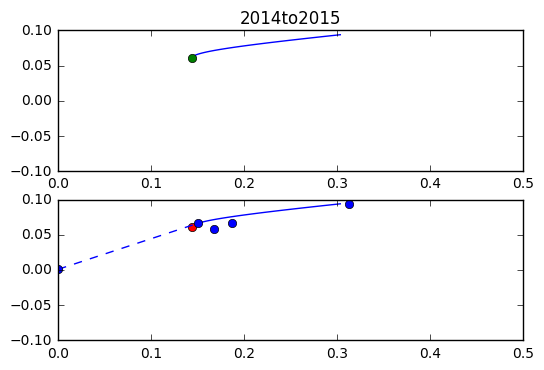

In [81]:
#选择3只数据比较完整的股票，对每个时间段作投资组合分析，包括：
#(d). 在没有无风险资产的情况下计算并画出有效前沿
#(e). 在有无风险资产的情形下计算并画出有效前沿，其中需要计算切线组合
#(f). 比较不同时间段计算的投资组合的差异，有效前沿，切线组合等

id_stock=['600615','600606','600621']
freq='M'
data_4p5=pd.concat([data1,data2,data3],axis=1)
rtn=data_4p5.resample('M').last().pct_change().dropna()
print(len(time_list))

for i in range(1,len(time_list)-1,2):
    temp = rtn[time_list[i]:time_list[i+1]]
    temp = temp.dropna()
    Mu=temp.mean().reshape((3,1))
    Sigma=temp.cov()
    Sigma=np.matrix(Sigma)
    N=len(Mu)
    
    Mu=np.matrix(Mu.reshape(N,1))
    onesv=np.matrix(np.ones((N,1)))
    SI=Sigma.I
    A=Mu.T*SI*onesv; A=A[0,0]
    B=Mu.T*SI*Mu; B=B[0,0]
    C=onesv.T*SI*onesv; C=C[0,0]
    D=B*C-A**2
    g=SI*onesv*B/D-SI*Mu*A/D
    h=SI*Mu*C/D-SI*onesv*A/D
    mmin=np.min(Mu)
    mmax=np.max(Mu)

    meanv=np.linspace(mmin,mmax,100)
    wv=list(map(lambda x: g+x*h,meanv))
    sigmav=list(map(lambda x: np.sqrt(x.T*Sigma*x)[0,0],wv))
    mumin=-g.T*Sigma*h/(h.T*Sigma*h)
    sigmamin=np.sqrt(g.T*Sigma*g-(g.T*Sigma*h)**2/(h.T*Sigma*h))
    muf=0.001
    wt=SI*(Mu-muf)
    wt=wt/(onesv.T*wt)
    mut=wt.T*Mu
    sigmat=np.sqrt(wt.T*Sigma*wt)

    Sig=rtn[time_list[i]:time_list[i+1]].std()
    plt.figure(i)
    ax1=plt.subplot(211)
    ax2=plt.subplot(212)
    plt.sca(ax1)
    plt.plot(sigmav,meanv)
    plt.plot(sigmamin,mumin,'o')
    plt.xlim([0,0.5]) 
    plt.ylim([-0.1,0.1])
    plt.title(time_list[i]+'to'+time_list[i+1])
    plt.sca(ax2)
    plt.plot(sigmav,meanv)
    plt.plot(Sig,Mu,"bo")
    plt.plot(sigmamin,mumin,"ro")
    plt.plot([0,sigmat.item(0)],[muf,mut.item(0)],"bo--")
    plt.xlim([0,0.5]) 
    plt.ylim([-0.1,0.1])